In [87]:
import pandas as pd
from dowhy import CausalModel
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta.tmle import TMLELearner
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel, GradientBoostedPropensityModel
from causalml.dataset import *
from causalml.metrics import *
from causalml.inference.tree import CausalRandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)


In [88]:
df = pd.read_csv("C:/Users/hanch/OneDrive/Desktop/research/NHEFS/NHEFS.csv")

covariates = [
    "qsmk",
    "wt82_71",
    "sex",
    "age",
    "race",
    "education",
    "smokeintensity",
    "smokeyrs",
    "active",
    "exercise",
    "wt71"
]

df = df[covariates]
df = df.dropna(subset=["qsmk", "wt82_71"])
print(df.head(1))


   qsmk   wt82_71  sex  age  race  education  smokeintensity  smokeyrs  \
0     0 -10.09396    0   42     1          1              30        29   

   active  exercise   wt71  
0       0         2  79.04  


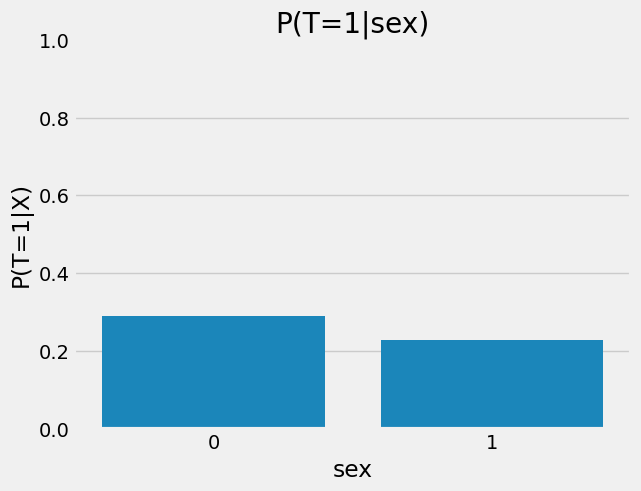

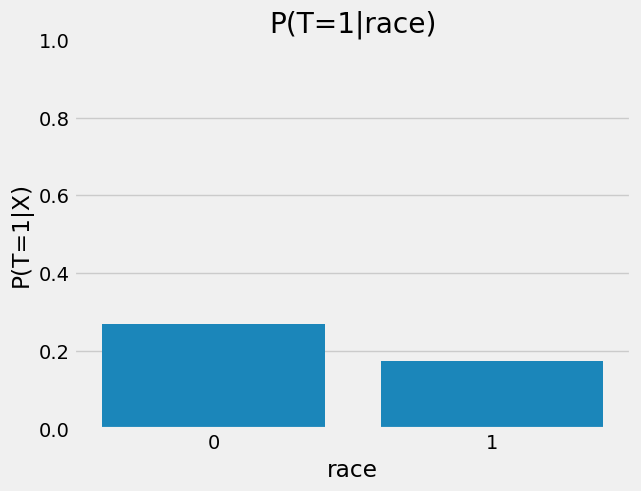

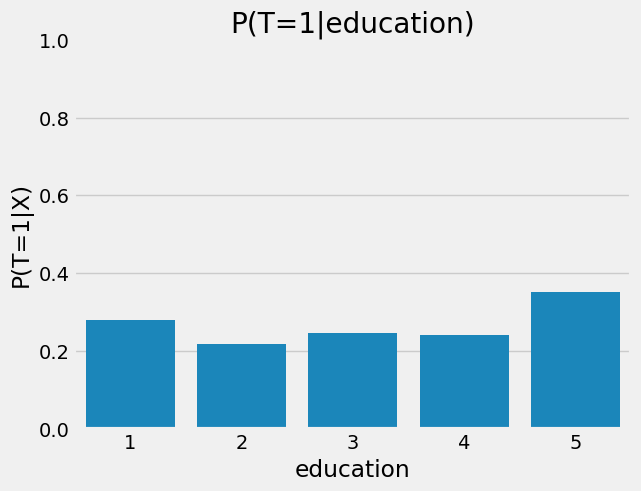

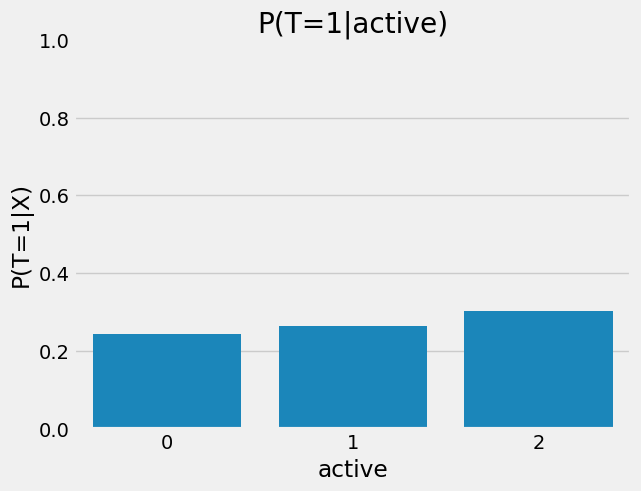

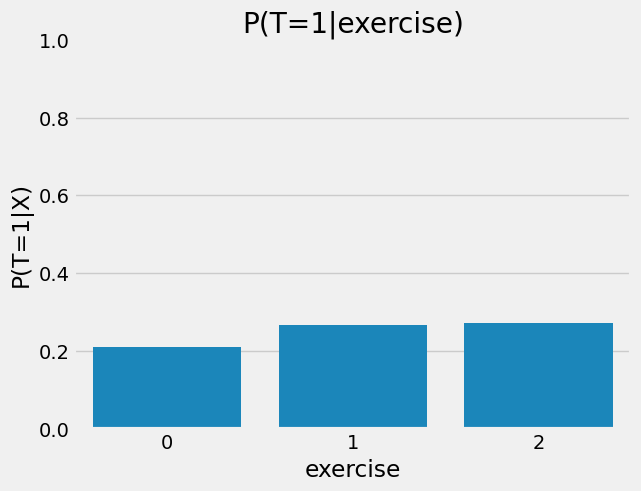

In [89]:
def barplot_categorical(df, cov):
    """
        plot P(T=1|X), X is a categorical covariate
    """
    prop = (
        df.groupby(cov)["qsmk"]
        .mean()
        .reset_index()
        .rename(columns={"qsmk": "P(T=1|X)"})
    )

    sns.barplot(x=cov, y="P(T=1|X)", data=prop)
    plt.ylim(0, 1)
    plt.title(f"P(T=1|{cov})")
    plt.show()
   
cov_list = [
    "sex",
    "race",
    "education",
    "active",
    "exercise",
] 

for cov in cov_list:
    barplot_categorical(df, cov)


age_bin
(24.951, 41.333]    701
(41.333, 57.667]    653
(57.667, 74.0]      212
Name: qsmk, dtype: int64


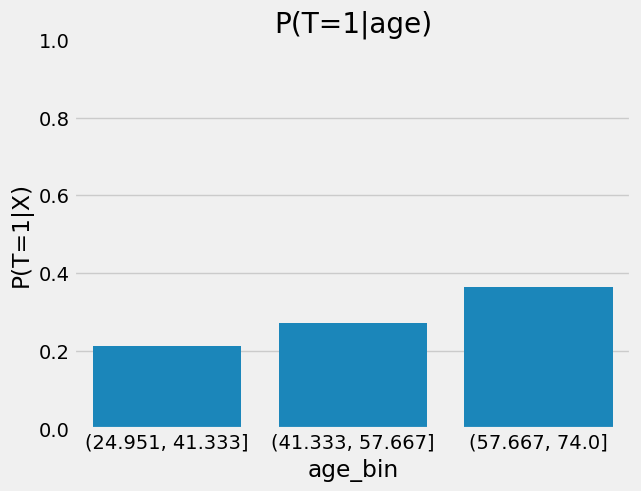

smokeintensity_bin
(0.921, 27.333]     1163
(27.333, 53.667]     388
(53.667, 80.0]        15
Name: qsmk, dtype: int64


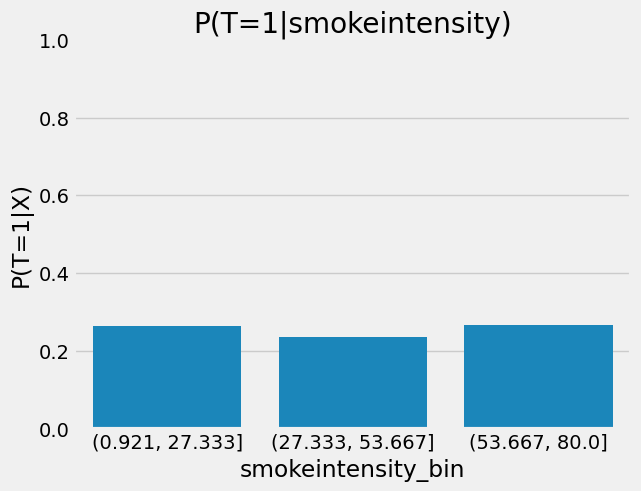

smokeyrs_bin
(0.937, 22.0]    730
(22.0, 43.0]     731
(43.0, 64.0]     105
Name: qsmk, dtype: int64


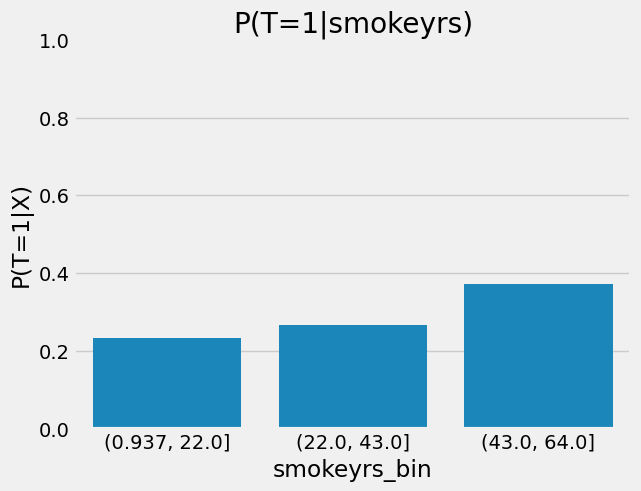

wt71_bin
(39.468, 76.963]     1077
(76.963, 114.347]     470
(114.347, 151.73]      19
Name: qsmk, dtype: int64


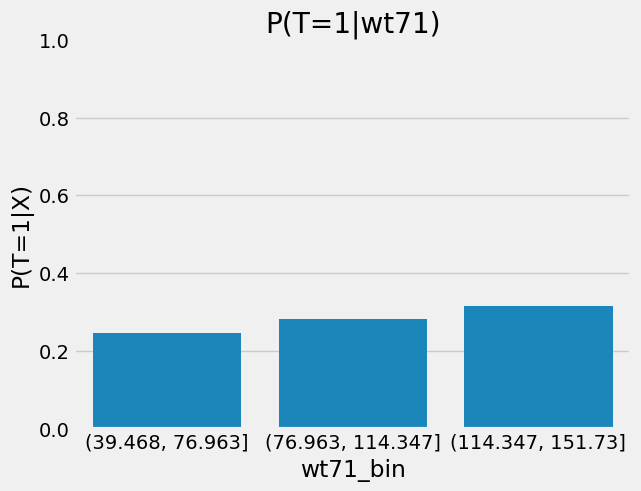

In [111]:
def barplot_continuous(df, cov):
    """
        plot P(T=1|X), X is a continuous covariate
    """
    
    nhefs = df.copy()
    nhefs[f"{cov}_bin"] = pd.cut(nhefs[f"{cov}"], bins=3)
    print(nhefs.groupby(f"{cov}_bin")["qsmk"].count())
    prop = (
        nhefs.groupby(f"{cov}_bin")["qsmk"]
        .mean()
        .reset_index()
        .rename(columns={"qsmk": "P(T=1|X)"})
    )

    sns.barplot(x=f"{cov}_bin", y="P(T=1|X)", data=prop)
    plt.ylim(0, 1)
    plt.title(f"P(T=1|{cov})")
    plt.show()
    
cov_list = ["age", "smokeintensity","smokeyrs","wt71"] 

for cov in cov_list:
    barplot_continuous(df, cov)

In [110]:
"""
    causal graph generated by GPT

"""

data = {
    "data": df,
    "treatment": ["qsmk"],
    "outcome": ["wt82_71"],
    "graph": """
graph [
  directed 1

  node [ id "qsmk" label "qsmk" ]
  node [ id "wt82_71" label "wt82_71" ]
  node [ id "smokeintensity" label "smokeintensity" ]
  node [ id "smokeyrs" label "smokeyrs" ]
  node [ id "active" label "active" ]
  node [ id "exercise" label "exercise" ]
  node [ id "wt71" label "wt71" ]
  node [ id "sex" label "sex" ]
  node [ id "age" label "age" ]
  node [ id "race" label "race" ]
  node [ id "education" label "education" ]

  edge [ source "qsmk" target "wt82_71" ]
  edge [ source "smokeintensity" target "qsmk" ]
  edge [ source "smokeyrs" target "qsmk" ]
  edge [ source "smokeintensity" target "wt71" ]
  edge [ source "smokeyrs" target "wt71" ]
  edge [ source "active" target "qsmk" ]
  edge [ source "exercise" target "qsmk" ]
  edge [ source "active" target "wt82_71" ]
  edge [ source "exercise" target "wt82_71" ]
  edge [ source "wt71" target "wt82_71" ]
  edge [ source "sex" target "qsmk" ]
  edge [ source "sex" target "wt71" ]
  edge [ source "age" target "qsmk" ]
  edge [ source "age" target "smokeyrs" ]
  edge [ source "age" target "wt71" ]
  edge [ source "race" target "qsmk" ]
  edge [ source "education" target "qsmk" ]
  edge [ source "education" target "smokeintensity" ]
  edge [ source "education" target "active" ]
  edge [ source "education" target "exercise" ]
]
"""
}


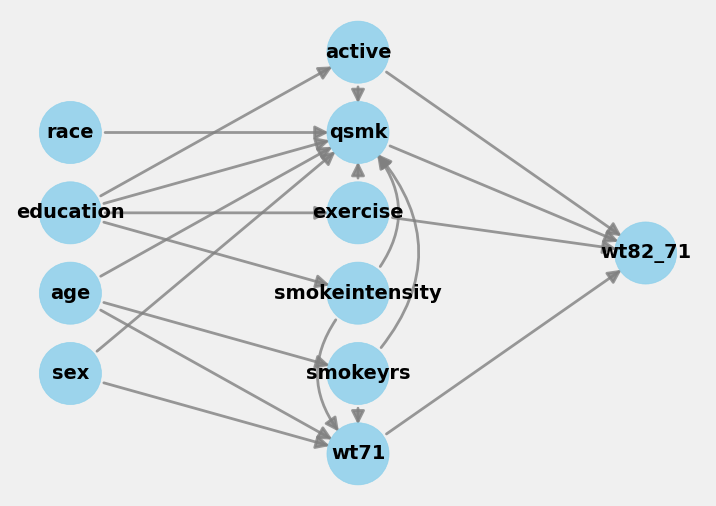

In [92]:
model = CausalModel(
    data = df,
    treatment = data["treatment"],
    outcome = data["outcome"],
    graph = data["graph"]
)
model.view_model()

In [93]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)
print(identified_estimand.get_backdoor_variables())
print()
print(identified_estimand)

['wt71', 'exercise', 'active']

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                     
───────(E[wt_82_71|wt71,exercise,active])
d[qsmk]                                  
Estimand assumption 1, Unconfoundedness: If U→{qsmk} and U→wt82_71 then P(wt82_71|qsmk,wt71,exercise,active,U) = P(wt82_71|qsmk,wt71,exercise,active)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                  -1⎤
 ⎢   d             ⎛   d           ⎞  ⎥
E⎢───────(wt₈₂ ₇₁)⋅⎜───────([qsmk])⎟  ⎥
 ⎣d[race]          ⎝d[race]        ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→wt82_71 then ¬(U →→{race})
Estimand assumption 2, Exclusion: If we remove {race}→{qsmk}, then ¬({race}→wt82_71)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                                                                

In [94]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals())

2.6612501705972433
(1.654399042349847, 3.707642691901755)


In [95]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

2.74416190435178
(1.8305368099283559, 3.690185219879927)


In [96]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

2.3618532040613025
(1.2078565756257982, 3.3370001558237545)


In [97]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

2.7380124584171126
(1.7795326684023047, 3.711105658286968)


In [98]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.generalized_linear_model",
           method_params={
            "glm_family": sm.families.Gaussian()
        }
    )
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

2.7380124584171144
(1.6061099840661899, 3.731201307379163)


In [105]:
y, X, treatment = (df["wt82_71"], df.drop(columns=["qsmk", "wt82_71"]), df["qsmk"])

from causalml.propensity import LogisticRegressionPropensityModel

pm = LogisticRegressionPropensityModel(
    #clip_bounds=(0.02, 0.98),
    calibrate=True
)

e = pm.fit_predict(X, treatment)
print(e[:30])


[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.999 0.001
 0.001 0.001 0.999 0.001 0.001 0.999 0.001 0.001 0.001 0.001 0.999 0.001
 0.001 0.001 0.999 0.001 0.001 0.001]


In [109]:
y, X, treatment = (df["wt82_71"], df[["wt71","exercise","active"]], df["qsmk"])

from causalml.propensity import LogisticRegressionPropensityModel

pm = LogisticRegressionPropensityModel(
    clip_bounds=(0.0, 1),
    calibrate=True
)

e = pm.fit_predict(X, treatment)
print(e[:30])

[0.25527704 0.25527704 0.25527704 0.25527704 0.25527704 0.25527704
 0.25527704 0.25527704 0.25527704 0.25527704 0.25527704 0.25527704
 0.25527704 0.25527704 0.25527704 0.25527704 0.25527704 0.25527704
 0.25527704 0.25527704 0.25527704 0.25527704 0.25527704 0.25527704
 0.25527704 0.16666667 0.25527704 0.25527704 0.25527704 0.25527704]


In [ ]:
learner_x = BaseXRegressor(learner=XGBRegressor())
ate = learner_x.estimate_ate(X=X, treatment=treatment, y=y, )